In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, emcee
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Isochrones

In [6]:
sys.path.append('/home/andy/Documents/software/')
import sqlutilpy, getdata

In [7]:
iso_properties = {'thin':{'age':6.9e9, 'feh':-0.3},
                 'thick':{'age':7.8e9, 'feh':-0.7},
                 'halo':{'age':12.5e9, 'feh':-1.5}}

In [9]:
for observable in ['age', 'feh']:
    query = f"""select distinct {observable} from isochrones.gaia_1804"""
    %time uniage=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

    for cmpt in iso_properties:
        iso_properties[cmpt]['iso'+observable] = uniage[observable][np.argmin(np.abs(uniage[observable] - iso_properties[cmpt][observable]))]

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.17 s
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4.81 s


In [10]:
for cmpt in iso_properties:
    query = f"""select gmag, g_bpmag, g_rpmag, mini, mass, age, feh, label from isochrones.gaia_1804
                    where age={iso_properties[cmpt]['isoage']}  and   feh={iso_properties[cmpt]['feh']}"""
    %time iso_properties[cmpt]['isochrone']=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1.14 s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1.05 s
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 832 ms


In [11]:
kwargs = {'thin':{'c':'tab:orange','alpha':1, 'linestyle':'-', 'label':'thin disk', 'linewidth':2}, 
           'thick':{'c':'tab:green','alpha':1, 'linestyle':'-', 'label':'thick disk', 'linewidth':2}, 
           'halo':{'c':'tab:purple','alpha':1, 'linestyle':'-', 'label':'halo', 'linewidth':2}}

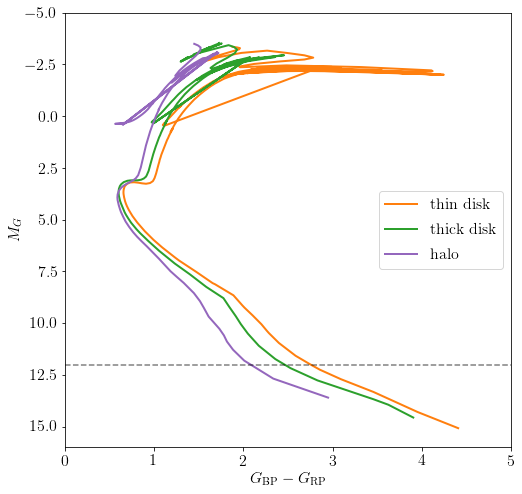

In [12]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot((iso_properties[cmpt]['isochrone']['g_bpmag']-iso_properties[cmpt]['isochrone']['g_rpmag'])[pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(0,5); plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$'); plt.ylabel(r'$M_G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

plt.savefig('figs/isochrones_HRdiag.png', bbox_inches='tight')

In [13]:
for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    iso_properties[cmpt]['isointerp'] = scipy.interpolate.interp1d(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
                                                                   iso_properties[cmpt]['isochrone']['gmag'][pre_death],
                                                                  bounds_error=False)
    iso_properties[cmpt]['massinterp'] = scipy.interpolate.interp1d(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
                                                                   iso_properties[cmpt]['isochrone']['mass'][pre_death],
                                                                  bounds_error=False)

# Draw initial-mass distribution

In [14]:
def imf_prob(x, ep1=1.3, ep2=2.3, m0=0.09, m1=0.5):
    
    mini = x[0]
    
    if mini<m0: return -1e30
    elif mini<m1:
        return -1.3*np.log(mini)
    else:
        return np.log(m1) - 2.3*np.log(mini)
    
    return lnl

In [15]:
nwalkers=100; nstep=100000; ndim=1

p0 = np.random.rand(nwalkers,ndim)*3 + 0.08

sampler = emcee.EnsembleSampler(nwalkers, ndim, imf_prob)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0, iterations=nstep), total=nstep):
    pass

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100000 [00:00<?, ?it/s]

In [16]:
mini_sample = sampler.chain[:,int(nstep/4):,0].flatten()

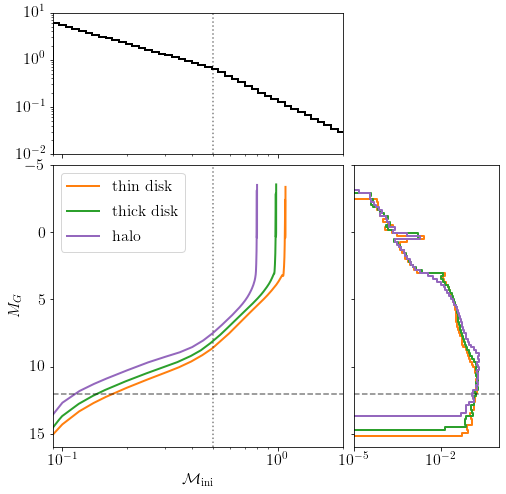

In [18]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey='row', sharex='col', 
                         gridspec_kw={'height_ratios':[1,2], 'width_ratios':[2,1]})

Mx = 12

plt.sca(axes[0,0])
plt.hist(mini_sample, bins=np.logspace(np.log10(0.09),2,100), histtype='step', density=True,
        color='k', linewidth=2);
plt.yscale('log'); plt.ylim(0.01,10)
ylims = axes[0,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,0])
for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.xlim(0.09,2); plt.ylim(16, -5); plt.xlabel(r'$\mathcal{M}_\mathrm{ini}$'); plt.ylabel(r'$M_G$');
plt.xscale('log')
plt.legend(loc='upper left')
xlims = axes[1,0].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)
ylims = axes[1,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,1])
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    g_sample[mini_sample<np.min(iso_properties[cmpt]['isochrone']['mini'])] = \
                    iso_properties[cmpt]['isochrone']['gmag'][0]
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,16,100))
    x = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    x = np.insert(np.repeat(x,2), (0,2*len(x)), (0,0))
    y = np.repeat(g_hist[1],2)
    plt.plot(x,y,**kwargs[cmpt])
plt.xscale('log'); plt.xlim(1e-5,1)

xlims = axes[1,1].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)

plt.sca(axes[0,1]); plt.axis('off')

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.05)

plt.savefig('figs/isochrones_Mini-MG_transform.png', bbox_inches='tight')

### Component mean mass

In [20]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mass_sample = iso_properties[cmpt]['massinterp'](mini_sample)
    iso_properties[cmpt]['mean_mass']=np.mean(mass_sample[g_sample<12])
    print(f"{cmpt} mean initial mass: {iso_properties[cmpt]['mean_mass']:.4f}Ms")

thin mean initial mass: 0.4127Ms
thick mean initial mass: 0.3688Ms
halo mean initial mass: 0.3083Ms


### Component mean weight
-  Mass fractions from Juric+ 2008

In [39]:
iso_properties['thin']['rho'] = 1.
iso_properties['thick']['rho'] = 0.12
iso_properties['halo']['rho'] = 0.005

for cmpt in iso_properties:
    iso_properties[cmpt]['w_0']=iso_properties[cmpt]['rho']*iso_properties['thin']['mean_mass']/iso_properties[cmpt]['mean_mass']
    print(f"{cmpt} w_0/w_thin: {iso_properties[cmpt]['w_0']:.4f}")

thin w_0/w_thin: 1.0000
thick w_0/w_thin: 0.1343
halo w_0/w_thin: 0.0067


In [40]:
total = np.sum([iso_properties[cmpt]['w_0'] for cmpt in iso_properties])
for cmpt in iso_properties:
    print(f"{cmpt} w: {iso_properties[cmpt]['w_0']/total:.4f}")

thin w_0/w_thin: 0.8765
thick w_0/w_thin: 0.1177
halo w_0/w_thin: 0.0059


In [43]:
iso_properties['thin']['hz'] = 0.3
iso_properties['thick']['hz'] = 0.9
iso_properties['halo']['hz'] = 3.74
R0=8.27

In [45]:
# Correcting for component normalisation
iso_properties['thin']['w'] = iso_properties['thin']['w_0'] * iso_properties['thin']['hz']**3
iso_properties['thick']['w'] = iso_properties['thick']['w_0'] * iso_properties['thick']['hz']**3
halo_norm = 8/(np.sqrt(np.pi)*R0**3) * scipy.special.gamma(iso_properties['halo']['hz']/2)/scipy.special.gamma((iso_properties['halo']['hz']-3)/2)
iso_properties['halo']['w'] = iso_properties['halo']['w_0'] / halo_norm


total = np.sum([iso_properties[cmpt]['w'] for cmpt in iso_properties])
for cmpt in iso_properties:
    print(f"{cmpt} w: {iso_properties[cmpt]['w']/total:.4f}")

thin w: 0.0120
thick w: 0.0436
halo w: 0.9443


### Magnitude distributions

In [22]:
Mx=12
fid_pars = {'Mmax':Mx,  'lat_min':60, 'R0':8.27,
            'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'components':['disk','disk','halo'], 'ncomponents':3}

M_arr = np.linspace(-5,Mx,100)

shared = {'w':1, 'alpha1':-0.1, 'alpha2':-.2, 'Mms2':8, 'Mms':9, 'Mms1':10}
fid_pars['fixed_pars']={'Mx':Mx, 
        0:dict({'alpha3':-.9, 'Mto':3.1}, **shared),
        1:dict({'alpha3':-.7, 'Mto':3.1}, **shared),
        2:dict({'alpha3':-.7, 'Mto':3.1}, **shared),}

for i, cmpt in enumerate(iso_properties):
    fid_pars['fixed_pars'][i]['fD'] = 1- \
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['fixed_pars'][i]['Mto'])/\
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['Mmax'])
    fid_pars['fixed_pars'][i]['fD'] = np.round(fid_pars['fixed_pars'][i]['fD'], 4)
    
    transitions = np.hstack((np.array([fid_pars['fixed_pars'][i][par] for par in ['Mms', 'Mms1', 'Mms2']]),
                np.array([fid_pars['fixed_pars'][i]['Mto'] for i in range(3)])))
    M_arr = np.sort(np.hstack((M_arr, transitions-1e-10, transitions+1e-10)))

fid_pars['free_pars']={0:[],1:[],2:[],'shd':[]}

components = dh_msto.M_model(M_arr, np.array([]), fid_pars=fid_pars, model='all')

Text(0.5, 0, '$M_G$')

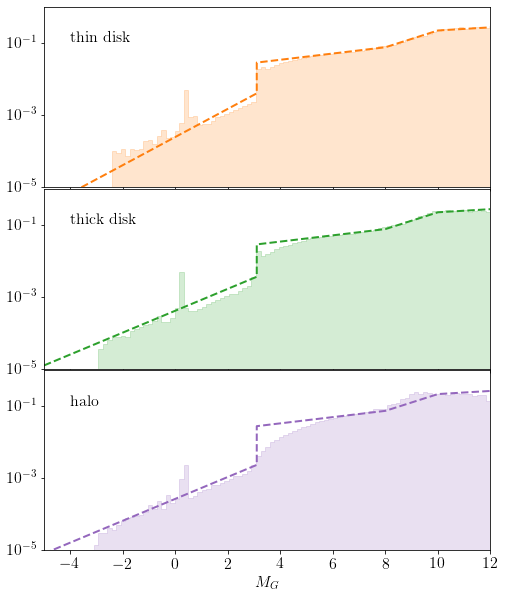

In [23]:
fig, axes = plt.subplots(3,1,figsize=(8,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.01)

for i, cmpt in enumerate(iso_properties):
    plt.sca(axes[i])
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,Mx,100))
    y = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    y = np.insert(np.repeat(y,2), (0,2*len(y)), (0,0))
    x = np.repeat(g_hist[1],2)
    plt.fill_between(x,np.zeros(len(y)),y,color=kwargs[cmpt]['c'], alpha=0.2)
    
    plt.plot(M_arr, components[:,i],c=kwargs[cmpt]['c'],linestyle='--',linewidth=2)
    
    plt.text(-4,0.1,kwargs[cmpt]['label'])
plt.yscale('log'); plt.ylim(1e-5,1); plt.xlim(-5,Mx)

plt.xlabel(r'$M_G$')

#plt.savefig('figs/isochrones_MG_model.png', bbox_inches='tight')

### Dwarf fraction

In [24]:
for i, cmpt in enumerate(iso_properties):
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    iso_properties[cmpt]['fD']=1-np.sum(g_sample<fid_pars['fixed_pars'][i]['Mto'])/np.sum(g_sample<12)
    print(f"{cmpt} fD: {iso_properties[cmpt]['fD']:.4f}")

thin fD: 0.9956
thick fD: 0.9949
halo fD: 0.9966


## Fixed parameters

In [25]:
Mx=12
fid_pars = {'Mmax':Mx,  'lat_min':60, 'R0':8.27,
            'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'components':['disk','disk','halo'], 'ncomponents':3}

M_arr = np.linspace(-5,Mx,100)

shared = {'Mms2':8, 'Mms':9, 'Mms1':10, 'Mto':3.1}

### Giant power law slope

In [26]:
def M_model(params, M, fD=0., Mto=4, Mms=8, Mms1=9, Mms2=7):
    
    alpha3 = params[0]
    if alpha3>0.: return -1e20

    # Latent variables
    n3 = -(4 + alpha3*5/np.log(10))

    pop1 = M>Mms1
    popg = M>Mms2
    pop2 = M>Mto
    
    log_AG = np.log(-alpha3) + np.log(1-fD)

    log_m = log_AG  + alpha3*(Mto-M)
    
    return np.sum(log_m)

In [28]:
nwalkers=10; ndim=1; nstep=500
chains = np.zeros((3,nwalkers,nstep,ndim))

for i, cmpt in enumerate(iso_properties):
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    lnlike = lambda x: M_model(x, g_sample[g_sample<shared['Mto']],
                                       Mto=shared['Mto'],
                                       Mms=shared['Mms'],
                                       Mms1=shared['Mms1'],
                                       Mms2=shared['Mms2'])
    
    p0_walkers = np.random.normal(-1,0.1,size=(nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike)
    for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
        pass
    
    chains[i]=sampler.chain

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

thin alpha3: -0.6000
thick alpha3: -0.7329
halo alpha3: -0.6465


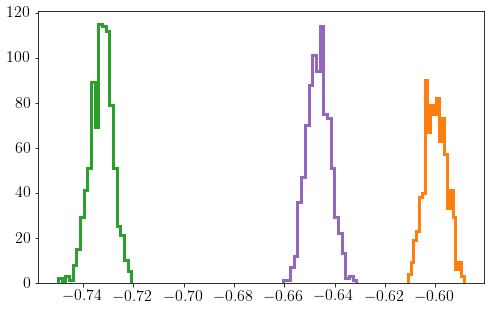

In [29]:
fig = plt.figure(figsize=(8,5))
for i, cmpt in enumerate(iso_properties):
    flatchain = chains[i,:,int(nstep/2)::3,0].flatten()
    plt.hist(flatchain, bins=20, color=kwargs[cmpt]['c'], histtype='step', linewidth=3)
    iso_properties[cmpt]['alpha3']=np.mean(flatchain)
    print(f"{cmpt} alpha3: {iso_properties[cmpt]['alpha3']:.4f}")

### Main sequence power law slope

In [30]:
shared

{'Mms2': 8, 'Mms': 9, 'Mms1': 10, 'Mto': 3.1}

In [31]:
def M_model(params, M, fD=1., Mto=4, Mms=8, Mms1=9, Mms2=7):
    
    alpha1, alpha2 = params
    if (alpha1>0.)|(alpha2>0.): return -1e20
    
    ep1=1.3; ep2=2.3;
    a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);

    alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
    Ag = 1/a1 * np.exp((alpha1-alphag)*(Mms-Mms1))

    # Latent variables
    n1 = -(4 + alpha1*5/np.log(10))
    ng = -(4 + alphag*5/np.log(10))
    n2 = -(4 + alpha2*5/np.log(10))

    pop1 = M>Mms1
    popg = M>Mms2

    log_Ams = np.log( fD*a1*a2 ) - \
              scipy.special.logsumexp(np.array([alpha1*(Mms-Mms1), alpha1*(Mms-Mx),
                                                alpha1*(Mms-Mms1)+alphag*(Mms1-Mms2), alpha1*(Mms-Mms1),
                                                alpha2*(Mms-Mto), alpha2*(Mms-Mms2)]),
                                    b=np.array([a2/alpha1, -a2/alpha1,
                                                a2/alphag, -a2/alphag,
                                                a1/alpha2, -a1/alpha2]))

    log_m = log_Ams  + np.where(pop1, - np.log(a1) + alpha1*(Mms-M),
                       np.where(popg, + np.log(Ag) + alphag*(Mms-M),
                                      - np.log(a2) + alpha2*(Mms-M)))
    
    return np.sum(log_m)

In [32]:
g_sample = np.array([])
size = 1e5
w_total = np.sum([iso_properties[cmpt]['w'] for cmpt in iso_properties])
for i, cmpt in enumerate(iso_properties):
    cmpt_size = int(size * iso_properties[cmpt]['w']/w_total)
    print(cmpt_size)
    cmpt_sample = np.random.choice(np.arange(len(mini_sample)), cmpt_size, replace=False)
    g_sample = np.hstack((g_sample, iso_properties[cmpt]['isointerp'](mini_sample)[cmpt_sample]))

87645
11767
586


In [34]:
nwalkers=10; ndim=2; nstep=500

lnlike = lambda x: M_model(x, g_sample[(g_sample>shared['Mto'])&(g_sample<Mx)],
                                   Mto=shared['Mto'],
                                   Mms=shared['Mms'], Mms1=shared['Mms1'], Mms2=shared['Mms2'])

p0_walkers = np.random.normal(-1,0.1,size=(nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/500 [00:00<?, ?it/s]

In [35]:
import corner

alpha1: -0.1160, alpha2: -0.2584


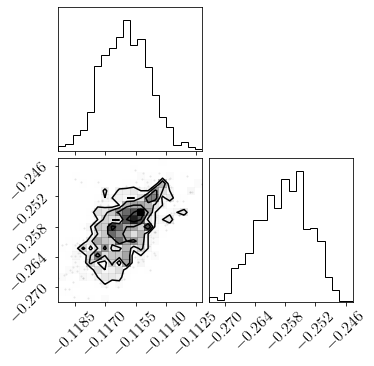

In [36]:
flatchain = sampler.chain[:,int(nstep/2)::3].reshape(-1,ndim)
corner.corner(flatchain);

shared['alpha1'], shared['alpha2'] = np.mean(flatchain, axis=0)
print(f"alpha1: {shared['alpha1']:.4f}, alpha2: {shared['alpha2']:.4f}")

# Plot with fitted parameters

In [323]:
fid_pars['fixed_pars']={'Mx':Mx}
for i, cmpt in enumerate(iso_properties):
    fid_pars['fixed_pars'][i] = dict({'alpha3':iso_properties[cmpt]['alpha3'], 
                                      'fD':iso_properties[cmpt]['fD'],
                                      'w':iso_properties[cmpt]['w']}, **shared)

In [326]:
for i, cmpt in enumerate(iso_properties):
    fid_pars['fixed_pars'][i]['fD'] = 1- \
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['fixed_pars'][i]['Mto'])/\
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['Mmax'])
    fid_pars['fixed_pars'][i]['fD'] = np.round(fid_pars['fixed_pars'][i]['fD'], 4)
    
    transitions = np.hstack((np.array([fid_pars['fixed_pars'][i][par] for par in ['Mms', 'Mms1', 'Mms2']]),
                np.array([fid_pars['fixed_pars'][i]['Mto'] for i in range(3)])))
    M_arr = np.sort(np.hstack((M_arr, transitions-1e-10, transitions+1e-10)))

fid_pars['free_pars']={0:[],1:[],2:[],'shd':[]}

components = dh_msto.M_model(M_arr, np.array([]), fid_pars=fid_pars, model='all')

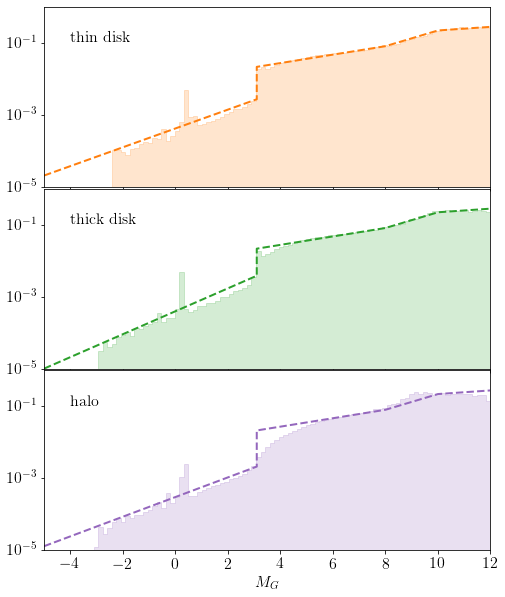

In [328]:
fig, axes = plt.subplots(3,1,figsize=(8,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.01)

for i, cmpt in enumerate(iso_properties):
    plt.sca(axes[i])
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,Mx,100))
    y = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    y = np.insert(np.repeat(y,2), (0,2*len(y)), (0,0))
    x = np.repeat(g_hist[1],2)
    plt.fill_between(x,np.zeros(len(y)),y,color=kwargs[cmpt]['c'], alpha=0.2)
    
    plt.plot(M_arr, components[:,i]/fid_pars['fixed_pars'][i]['w'], 
             c=kwargs[cmpt]['c'],linestyle='--',linewidth=2)
    
    plt.text(-4,0.1,kwargs[cmpt]['label'])
plt.yscale('log'); plt.ylim(1e-5,1); plt.xlim(-5,Mx)

plt.xlabel(r'$M_G$')

plt.savefig('figs/isochrones_MG_model_fit.png', bbox_inches='tight')

In [324]:
fid_pars['fixed_pars']

{'Mx': 12,
 0: {'alpha3': -0.6021901421628681,
  'fD': 0.0044522248674430795,
  'w': 1.0,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11579438897983448,
  'alpha2': -0.2697959854426695},
 1: {'alpha3': -0.7334036765652955,
  'fD': 0.0052265327993776135,
  'w': 0.13416105719126437,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11579438897983448,
  'alpha2': -0.2697959854426695},
 2: {'alpha3': -0.6286748783859065,
  'fD': 0.0034288680937870912,
  'w': 0.006689311156602675,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11579438897983448,
  'alpha2': -0.2697959854426695}}

# Old notes

In [185]:
def M_model(M):

    alpha1=-0.5; alpha2=-0.5
    Mms2=7.99; Mms=8; Mms1=8.01; 
    Mto=-10
    alpha3=-1.
    fD=0.99
    

    ep1=1.3; ep2=2.3;
    a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);

    alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
    Ag = 1/a1 * np.exp((alpha1-alphag)*(Mms-Mms1))

    # Latent variables
    n1 = -(4 + alpha1*5/np.log(10))
    ng = -(4 + alphag*5/np.log(10))
    n2 = -(4 + alpha2*5/np.log(10))
    n3 = -(4 + alpha3*5/np.log(10))

    pop1 = M>Mms1
    popg = M>Mms2
    pop2 = M>Mto

    
    b=np.array([a2/alpha1, -a2/alpha1,
                a2/alphag, -a2/alphag,
                a1/alpha2, -a1/alpha2])
    exponent = np.array([alpha1*(Mms-Mms1), alpha1*(Mms-Mx),
                                                alpha1*(Mms-Mms1)+alphag*(Mms1-Mms2), alpha1*(Mms-Mms1),
                                                alpha2*(Mms-Mto), alpha2*(Mms-Mms2)])
    
    log_Ams = np.log( fD*a1*a2 ) - \
              scipy.special.logsumexp(exponent,
                                    b=b)
    log_AG = np.log(-alpha3) + np.log(1-fD)

    log_m = np.where(pop1,  - np.log(a1) + alpha1*(Mms-M),
            np.where(popg,  + np.log(Ag) + alphag*(Mms-M),
            np.where(pop2,  - np.log(a2) + alpha2*(Mms-M),
                           log_AG  + alpha3*(Mto-M))))

    return np.sum(np.log(m))

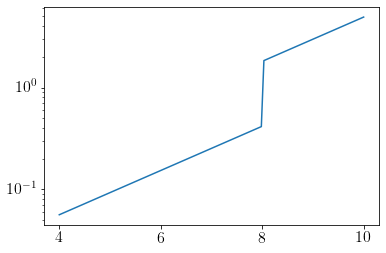

In [186]:
plt.plot(MG, M_model(MG))
plt.yscale('log')

In [95]:
alpha1=-0.5; alpha2=-0.5
ep1=1.3; ep2=2.3;
mb = 0.5
a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
Mms=8

In [104]:
mag_sample = np.zeros(len(mini_sample))
mag_sample[mini_sample<mb] = (-2.5*a1/np.log(10))*(np.log(mini_sample[mini_sample<mb]) - np.log(mb)) + Mms
mag_sample[mini_sample>mb] = (-2.5*a2/np.log(10))*(np.log(mini_sample[mini_sample>mb]) - np.log(mb)) + Mms

In [107]:
def model(MG, Mto=4, Mx=12):
    
    norm = mb**(-ep2)/a2 * (np.exp(a2*Mms) - np.exp(a2*Mto)) + mb**(-ep1)/a1 * (np.exp(a1*Mx - np.exp(a1*Mms)))
    
    result = np.zeros(MG.size)
    result[MG<Mms] = mb**(-ep1)*np.exp(-alpha1*MG[MG<Mms])
    result[MG>Mms] = mb**(-ep2)*np.exp(-alpha2*MG[MG>Mms])
    
    return result/norm

In [136]:
def model(MG, Mto=4, Mx=12):
    
    norm=1.
    
    result = np.zeros(MG.size)
    result[MG<Mms] = - np.log(a1) + alpha1*(Mms-MG[MG<Mms])
    result[MG>Mms] = - np.log(a2) + alpha2*(Mms-MG[MG>Mms])
    
    return np.exp(result)/norm

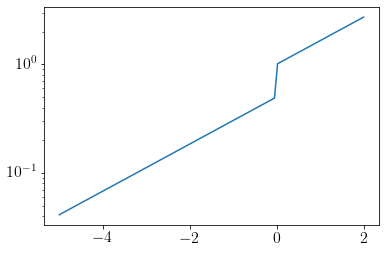

In [121]:
Mms

8

In [120]:
MG.size

120

In [130]:
a1

0.5526204223185711

In [137]:
model(MG)

array([0.24489736, 0.25114972, 0.25756171, 0.26413741, 0.27088098,
       0.27779672, 0.28488902, 0.29216239, 0.29962146, 0.30727095,
       0.31511575, 0.32316083, 0.3314113 , 0.33987241, 0.34854954,
       0.3574482 , 0.36657405, 0.37593288, 0.38553065, 0.39537346,
       0.40546756, 0.41581937, 0.42643546, 0.43732259, 0.44848768,
       0.45993781, 0.47168028, 0.48372253, 0.49607223, 0.50873723,
       0.52172556, 0.5350455 , 0.54870551, 0.56271426, 0.57708066,
       0.59181384, 0.60692317, 0.62241825, 0.63830893, 0.65460531,
       0.67131774, 0.68845684, 0.70603352, 0.72405894, 0.74254456,
       0.76150213, 0.7809437 , 0.80088161, 0.82132856, 0.84229753,
       0.86380184, 0.88585517, 0.90847154, 0.93166531, 0.95545124,
       0.97984443, 1.00486039, 1.03051502, 1.05682463, 1.08380594,
       1.1114761 , 1.13985269, 1.16895375, 1.19879778, 1.22940374,
       1.26079109, 1.29297977, 1.32599025, 1.35984351, 1.39456105,
       1.43016496, 1.46667785, 1.50412293, 1.54252401, 1.58190

In [148]:
M_model(MG)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

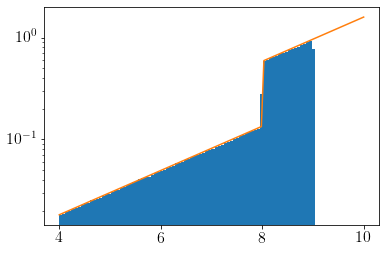

In [193]:
plt.hist(mag_sample, bins=100, range=(4,10), density=True);

MG=np.linspace(4,10,120)
plt.plot(MG, M_model(MG)/3.1)
plt.yscale('log')

In [ ]:

    # Input Parameters
    ncomponents=fid_pars['ncomponents']
    transformed_params = combined_params(params, fid_pars, ncomponents=ncomponents)

    dist_cmpts = np.zeros((len(M), ncomponents))
    weights = np.zeros(ncomponents)
    for j in range(ncomponents):
        alpha1=transformed_params[j]['alpha1']; alpha2=transformed_params[j]['alpha2']; alpha3=transformed_params[j]['alpha3']
        Mms=transformed_params[j]['Mms']; Mms1=transformed_params[j]['Mms1']; Mms2=transformed_params[j]['Mms2']; Mto=transformed_params[j]['Mto'];
        fD=transformed_params[j]['fD']; Mx=fid_pars['Mmax']



        alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
        Ag = 1/a1 * np.exp((alpha1-alphag)*(Mms-Mms1))

        # Latent variables
        n1 = -(4 + alpha1*5/np.log(10))
        ng = -(4 + alphag*5/np.log(10))
        n2 = -(4 + alpha2*5/np.log(10))
        n3 = -(4 + alpha3*5/np.log(10))

        pop1 = M>Mms1
        popg = M>Mms2
        pop2 = M>Mto

        log_Ams = np.log( fD*a1*a2 ) - \
                  scipy.special.logsumexp(np.array([alpha1*(Mms-Mms1), alpha1*(Mms-Mx),
                                                    alpha1*(Mms-Mms1)+alphag*(Mms1-Mms2), alpha1*(Mms-Mms1),
                                                    alpha2*(Mms-Mto), alpha2*(Mms-Mms2)]),
                                        b=np.array([a2/alpha1, -a2/alpha1,
                                                    a2/alphag, -a2/alphag,
                                                    a1/alpha2, -a1/alpha2]))
        log_AG = np.log(-alpha3) + np.log(1-fD)

        log_m = np.where(pop1, log_Ams - np.log(a1) + alpha1*(Mms-M),
                np.where(popg, log_Ams + np.log(Ag) + alphag*(Mms-M),
                np.where(pop2, log_Ams - np.log(a2) + alpha2*(Mms-M),
                               log_AG  + alpha3*(Mto-M))))

        m_dist = np.exp(log_m)
        m_dist[M>fid_pars['Mmax']]=0.
        dist_cmpts[:,j] = m_dist

        weights[j] = transformed_params[j]['w']

    if model=='combined': return  np.sum(weights*dist_cmpts, axis=1)
    elif model=='all':    return        (weights*dist_cmpts)

### Tip of the RGB

In [284]:
for cmpt in iso_properties:
    print(cmpt, np.min(iso_properties[cmpt]['isochrone']['gmag']))

thin -3.996
thick -3.532
halo -3.718


# Young disk

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, emcee
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Isochrones

In [7]:
sys.path.append('/home/andy/Documents/software/')
import sqlutilpy, getdata

In [43]:
iso_properties = {'thin':{'age':5.7e9,   'feh':-0.3},
                 'thick':{'age':7.8e9, 'feh':-0.7},
                 'halo':{'age':13e9, 'feh':-1.5}}

In [44]:
for observable in ['age', 'feh']:
    query = f"""select distinct {observable} from isochrones.gaia_1804"""
    %time uniage=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

    for cmpt in iso_properties:
        iso_properties[cmpt]['iso'+observable] = uniage[observable][np.argmin(np.abs(uniage[observable] - iso_properties[cmpt][observable]))]

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.24 s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 4.74 s


In [45]:
for cmpt in iso_properties:
    query = f"""select gmag, g_bpmag, g_rpmag, mini, mass, age, feh, label from isochrones.gaia_1804
                    where age={iso_properties[cmpt]['isoage']}  and   feh={iso_properties[cmpt]['feh']}"""
    %time iso_properties[cmpt]['isochrone']=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 911 ms
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 454 ms
CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 453 ms


In [46]:
kwargs = {'thin':{'c':'tab:orange','alpha':1, 'linestyle':'-', 'label':'thin disk', 'linewidth':2}, 
           'thick':{'c':'tab:green','alpha':1, 'linestyle':'-', 'label':'thick disk', 'linewidth':2}, 
           'halo':{'c':'tab:purple','alpha':1, 'linestyle':'-', 'label':'halo', 'linewidth':2}}

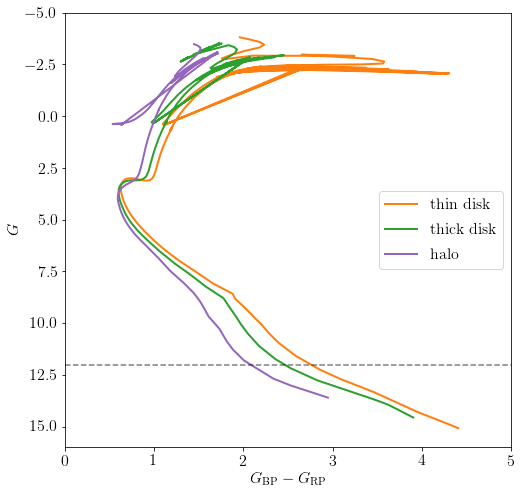

In [47]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot((iso_properties[cmpt]['isochrone']['g_bpmag']-iso_properties[cmpt]['isochrone']['g_rpmag'])[pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(0,5); plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$'); plt.ylabel(r'$G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

In [15]:
iso_properties['thin']['isochrone'].keys()

odict_keys(['gmag', 'g_bpmag', 'g_rpmag', 'mini', 'mass', 'age', 'feh', 'label'])

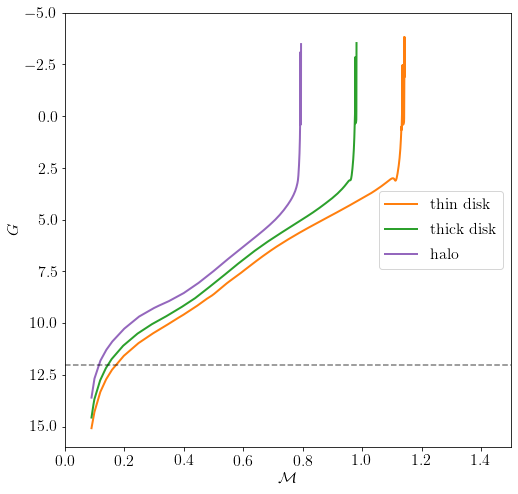

In [48]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(0,1.5); plt.xlabel(r'$\mathcal{M}$'); plt.ylabel(r'$G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

In [49]:
grad.shape

(328,)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


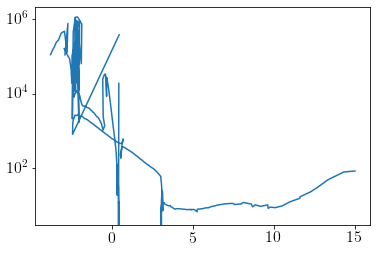

In [50]:
cmpt = 'thin'
pre_death = iso_properties[cmpt]['isochrone']['label']<9
_mini_test = iso_properties[cmpt]['isochrone']['mini'][pre_death]
_gmag_test = iso_properties[cmpt]['isochrone']['gmag'][pre_death]

grad = (_gmag_test[1:]-_gmag_test[:-1])/(_mini_test[1:]-_mini_test[:-1])

plt.plot(_gmag_test[1:], np.abs(grad))
plt.yscale('log')

In [68]:
interp = scipy.interpolate.interp1d(_gmag_test, _mini_test)
grad = 0.1/(interp(np.arange(-2.,10.1,0.1))-interp(np.arange(-2.1,10.,0.1)))
Mini = interp(np.arange(-2.05,10.,0.1))

In [66]:
np.arange(-2.05,10.1,0.1).shape

(122,)

In [69]:
print(np.vstack(((np.arange(-2.05,10.,0.1), Mini, grad))).T)

[[-2.05000000e+00  1.13665392e+00 -7.94097001e+01]
 [-1.95000000e+00  1.13883873e+00 -1.91323345e+01]
 [-1.85000000e+00  1.13996573e+00  2.82865889e+01]
 [-1.75000000e+00  1.13569344e+00 -8.79915162e+02]
 [-1.65000000e+00  1.14098989e+00 -4.55202743e+01]
 [-1.55000000e+00  1.13875214e+00  2.07208943e+01]
 [-1.45000000e+00  1.13632086e+00 -4.42403280e+01]
 [-1.35000000e+00  1.14116740e+00 -5.27225953e+01]
 [-1.25000000e+00  1.13914272e+00 -5.03789367e+01]
 [-1.15000000e+00  1.14111006e+00 -3.08034786e+02]
 [-1.05000000e+00  1.13442701e+00  2.41380401e+01]
 [-9.50000000e-01  1.13435328e+00 -8.04927523e+01]
 [-8.50000000e-01  1.14064292e+00 -8.44120251e+01]
 [-7.50000000e-01  1.14014217e+00 -8.87100398e+01]
 [-6.50000000e-01  1.13944453e+00  6.17571741e+03]
 [-5.50000000e-01  1.13918618e+00  2.88720866e+01]
 [-4.50000000e-01  1.13786336e+00  4.69240836e+01]
 [-3.50000000e-01  1.14065960e+00 -1.44063597e+02]
 [-2.50000000e-01  1.13456161e+00 -5.68919968e+01]
 [-1.50000000e-01  1.13350737e+

In [52]:
order = np.argsort(_gmag_test[1:]+_gmag_test[:-1])
print(np.vstack(((_gmag_test[1:]+_gmag_test[:-1])/2, _mini_test[1:], grad)).T[order])

[[-3.75350000e+00  1.14139867e+00 -1.10097515e+05]
 [-3.64150000e+00  1.14139771e+00 -1.42600359e+05]
 [-3.51950000e+00  1.14139688e+00 -1.74776286e+05]
 [-3.38650000e+00  1.14139616e+00 -2.36537494e+05]
 [-3.23450000e+00  1.14139557e+00 -2.73489933e+05]
 [-3.05350000e+00  1.14139497e+00 -4.17365772e+05]
 [-2.93750000e+00  1.14139342e+00             inf]
 [-2.91350000e+00  1.14139354e+00 -1.09060403e+05]
 [-2.87000000e+00  1.14139450e+00 -4.69667319e+05]
 [-2.86300000e+00  1.14139342e+00 -1.60146420e+05]
 [-2.83000000e+00  1.14139378e+00  7.55033556e+05]
 [-2.76300000e+00  1.14139414e+00 -1.28635347e+05]
 [-2.69500000e+00  1.14139211e+00 -1.05695831e+05]
 [-2.58650000e+00  1.14139092e+00 -8.48168515e+04]
 [-2.51950000e+00  1.14138985e+00 -4.50875537e+04]
 [-2.49000000e+00  1.14138889e+00 -1.91754554e+04]
 [-2.46150000e+00  1.14134729e+00 -2.09716882e+03]
 [-2.45750000e+00  1.14134586e+00 -5.24273881e+03]
 [-2.45200000e+00  1.14138806e+00 -1.00654253e+05]
 [-2.44500000e+00  1.13511789e+